In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd

# import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sindyauto_path = '/home/sihoon/works/HAVOK/SindyAutoencoders_master/src'
if sindyauto_path not in sys.path:
    sys.path.insert(0, sindyauto_path)
from autoencoder import full_network, build_network_layers
from training import create_feed_dictionary
from sindy_utils import sindy_simulate

In [2]:
data_path = os.getcwd() + '/'
save_name = 'trained_models/cmapss_2023_08_11_14_06_53_028563'

params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






# Single trajectory plots


In [3]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
const_labels = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']
col_names = index_names + setting_names + sensor_names
tmp_labels = index_names + setting_names + const_labels
remain_labels = [n for n in col_names if n not in tmp_labels]
print(f'remain_labels:{remain_labels}')

dataset_path = './../Dataset/CMaps'

dfvalid = pd.read_csv(os.path.join(dataset_path, 'test_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
X_test = dfvalid.drop(columns=index_names+setting_names+const_labels).copy()

print('Shape of the validation dataset : ',X_test.shape)
X_test.columns


remain_labels:['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
Shape of the validation dataset :  (13096, 15)


Index(['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')

In [4]:
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from mysindy_util import generate_list_increasing_by_dt
import pysindy as ps

scaler = MinMaxScaler()

X_test_scal=scaler.fit_transform(X_test)


window_length = 11
poly_order = 2

X_test_scal_df = pd.DataFrame(X_test_scal, columns=remain_labels)
X_test_scal_smoot_df = X_test_scal_df.apply(lambda col: savgol_filter(col, window_length, poly_order))
X_test_scal_smoot = X_test_scal_smoot_df.values

differentiation_method = ps.FiniteDifference(order=2)
t_max = X_test_scal_smoot.shape[0]
t = generate_list_increasing_by_dt(size=t_max, dt=1)
Xdot = differentiation_method._differentiate(X_test_scal_smoot, t)

test_data = {
    't': t,
    'x': X_test_scal_smoot,
    'dx': Xdot
}

OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-35
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 36 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #289: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #289: KMP_AFFINITY: topology layer "L3 cache" is equivalent to "socket".
OMP: Info #289: KMP_AFFINITY: topology layer "L2 cache" is equivalent to "core".
OMP: Info #289: KMP_AFFINITY: topology layer "L1 cache" is equivalent to "core".
OMP: Info #191: KMP_AFFINITY: 1 socket x 18 cores/socket x 2 threads/core (18 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 18 maps to socket 0 core 0 thread 1 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 19 maps to socket 0 core 1 thread 1 
OMP: 

In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]



INFO:tensorflow:Restoring parameters from /home/sihoon/works/HAVOK/sindy_test/Test_sindy/trained_models/cmapss_2023_08_10_13_16_12_556414


OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18340 thread 9 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18339 thread 10 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18363 thread 12 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18362 thread 11 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18364 thread 13 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18365 thread 14 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18366 thread 15 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18367 thread 16 bound to OS proc set 8
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18369 thread 18 bound to OS proc set 10
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18368 thread 17 bound to OS proc set 9
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18370 thread 19 bound to OS proc set 11
OMP: Info #254: KMP_AFFINITY: pid 18240 tid 18372 thread 21 bound to OS proc set 13
OM

In [6]:
z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])
print(z_sim.shape)

# z_sim -> x_decode
# x_decode, _, _ = build_network_layers(z_sim, input_dim=z_sim.shape[1], output_dim=X_test_scal_smoot.shape[1],
#                      widths=[], activation=None, name='decoder')

(13096, 10)


/home/sihoon/anaconda3/envs/SINDy_test_python37/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [7]:
print(test_set_results['sindy_coefficients'].shape)
print(test_set_results['z'].shape)
print(test_set_results['x_decode'].shape)

(296, 10)
(13096, 10)
(13096, 15)


No handles with labels found to put in legend.


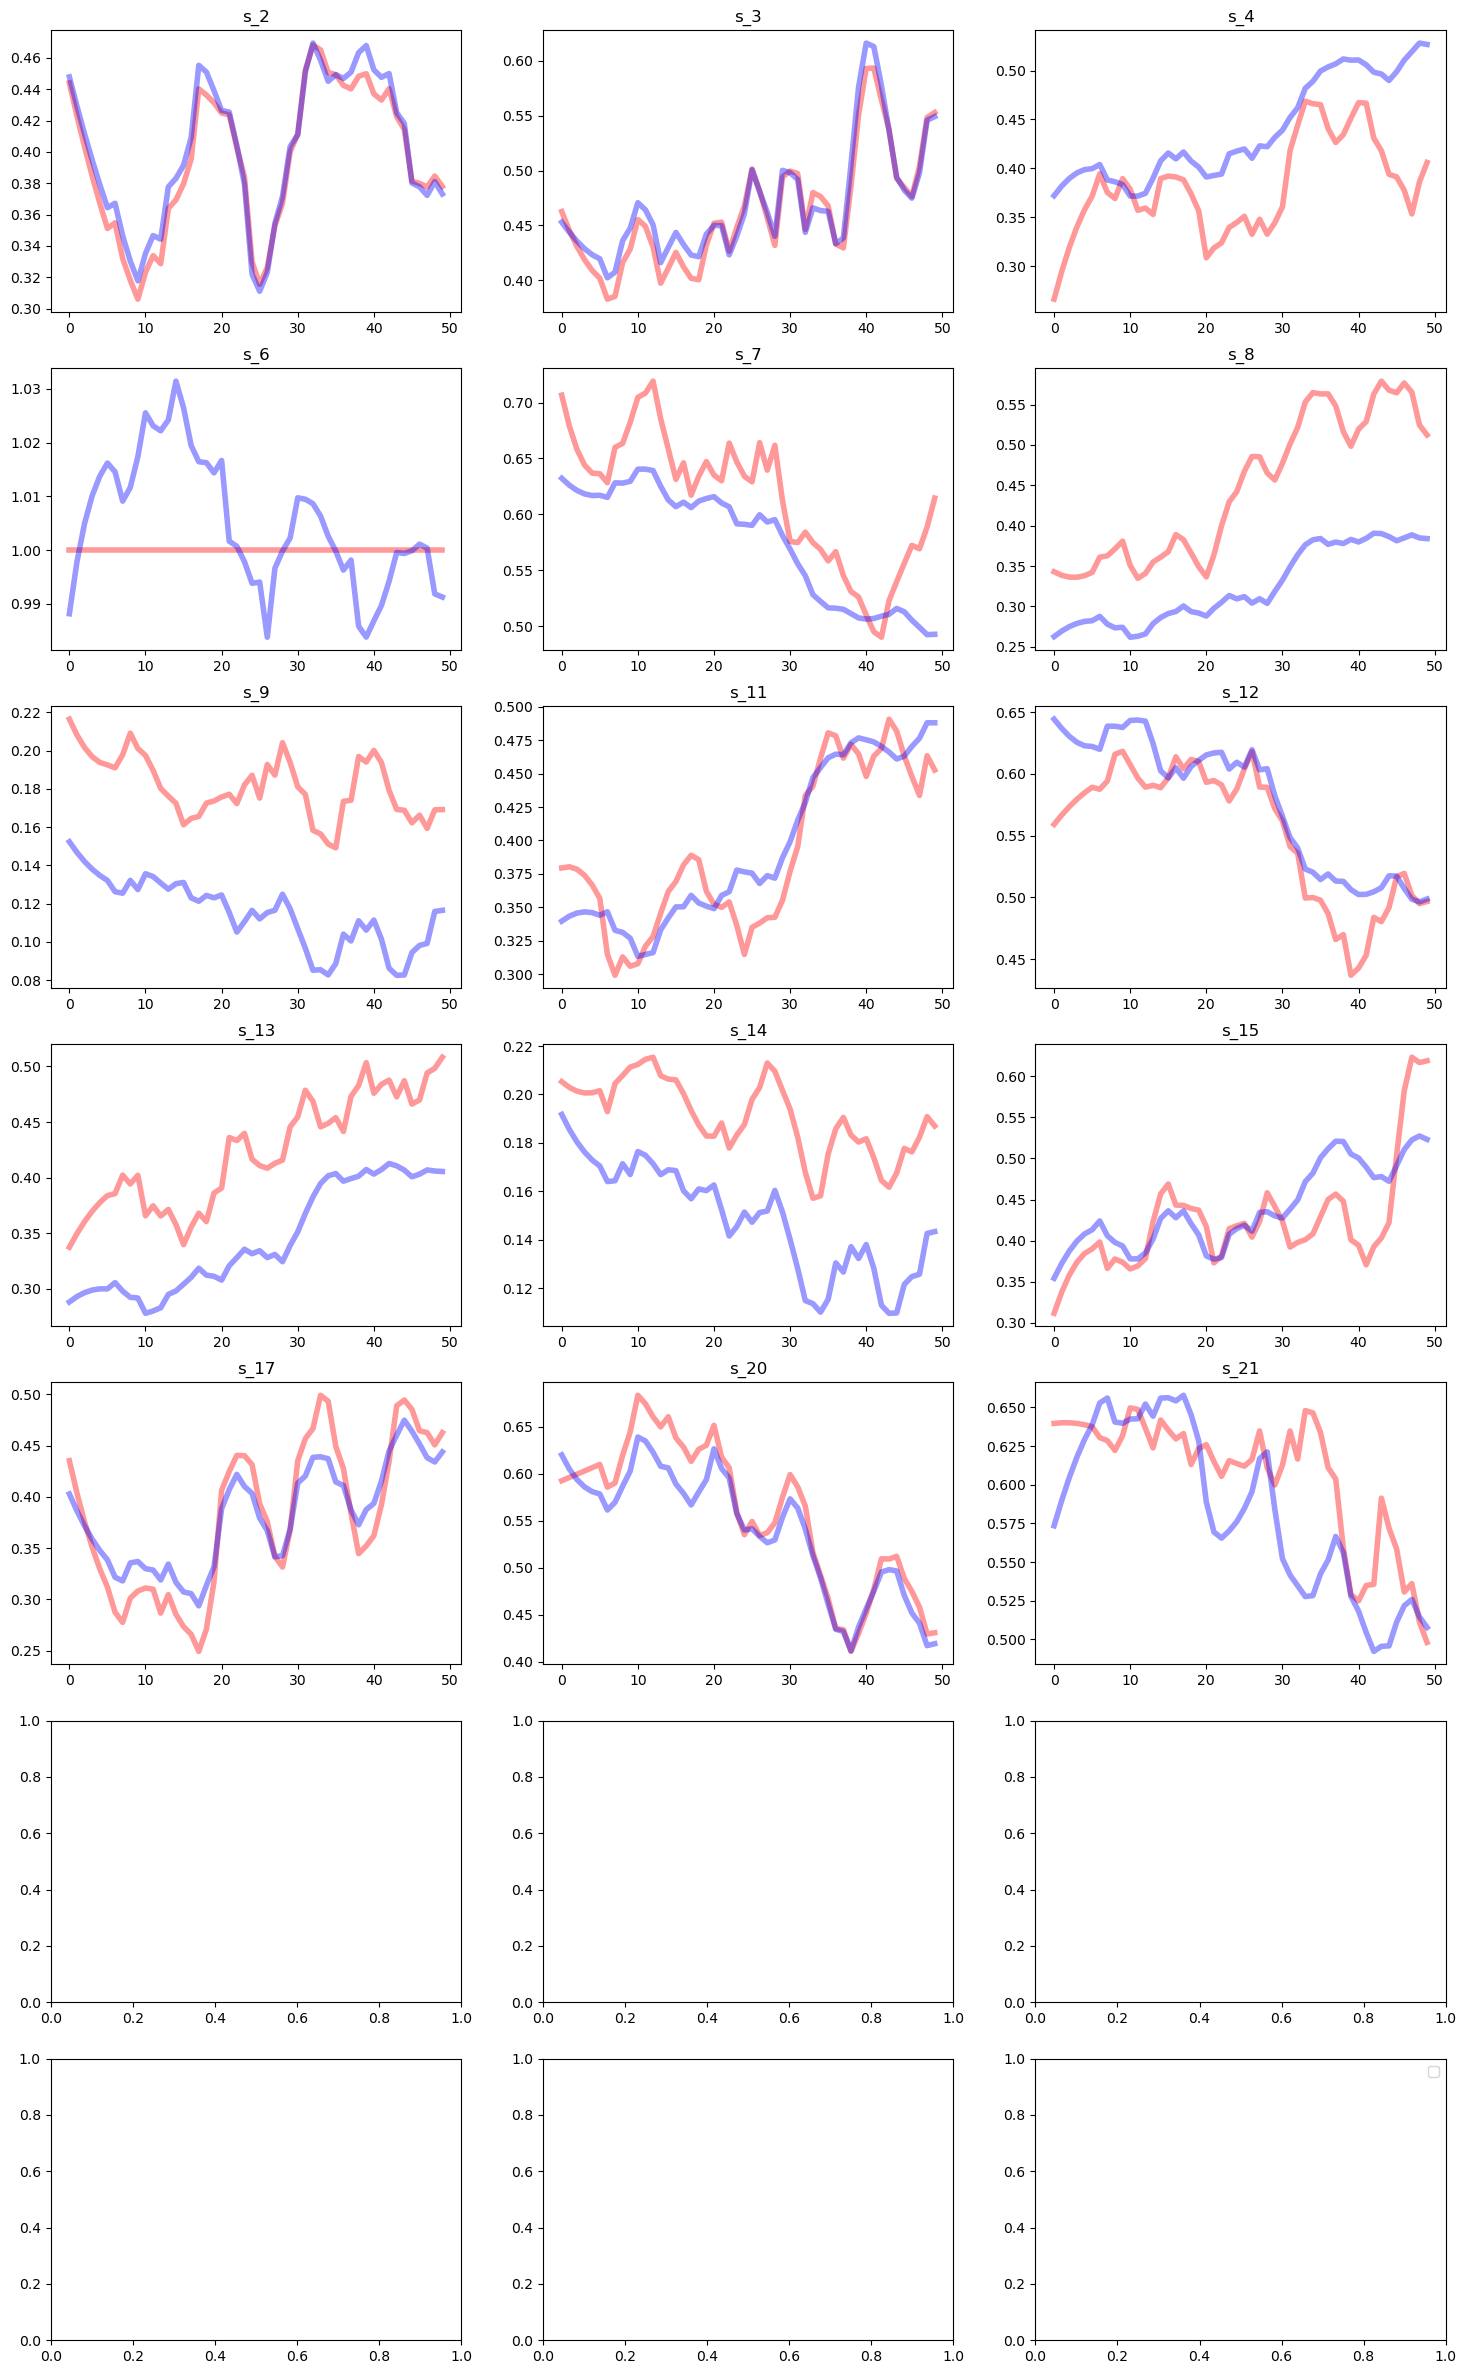

In [8]:
plt.ion()

x_idx = 5
y_idx = 8
time_dur = 50
x0 = X_test_scal_smoot[0, x_idx]
y0 =X_test_scal_smoot[0, y_idx]

x_test = X_test_scal_smoot[:50, x_idx]
y_test = X_test_scal_smoot[:50, y_idx]


x_test_hat = test_set_results['x_decode'][:50, x_idx]
y_test_hat = test_set_results['x_decode'][:50, y_idx]


fig, axs = plt.subplots(7, 3,figsize=(18,30))

for i, ax in enumerate(axs.flatten()):
    if i < X_test_scal_smoot.shape[1]:
        ax.plot(X_test_scal_smoot[:time_dur, i], 'r', label="x", alpha=0.4, linewidth=4)
        ax.plot(test_set_results['x_decode'][:time_dur, i], 'b', label="x_decode", alpha=0.4, linewidth=4)
        # ax.plot(test_set_results['x'][:time_dur, i], 'g', label="x_hat", alpha=0.4, linewidth=4)
        ax.set_title(X_test_scal_smoot_df.columns[i])


# for i in range(X_test_scal_smoot.shape[1]):
#     axs[i].plot(X_test_scal_smoot[:time_dur, i], 'r', label="x", alpha=0.4, linewidth=4)
#     axs[i].plot(test_set_results[:time_dur, i], 'b', label="x_hat", alpha=0.4, linewidth=4)


plt.legend()
plt.show()